In [6]:
from model import UNET
from utils import load_checkpoint
import torch
%load_ext autoreload
%autoreload 2

DEVICE = 'cuda:1'
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
load_checkpoint(torch.load("checkpoint_stepLR1e-4.pth", map_location='cpu'), model)
model.eval()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
=> Loading checkpoint


UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(2048, 1024, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(2048, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(

In [3]:
from utils import get_test_loader
loader = get_test_loader(batch_size=1, num_workers=1, pin_memory=False)

In [4]:
def combine_patches(patches, n_patch_x, n_patch_y, step_x, step_y, solve_overlap='mean'):
    """combine n_patch_x * n_patch_y patches of matrices of size (s1, s2) into a 
    large matrix of size (s1 + step_x * (n_patch_x - 1), s2 + step_y * (n_patch_y - 1))
    patches: must be of shape (n_patch_x, n_patch_y, num_channels, s1, s2)
    """
    
    n_c, shape_x, shape_y = patches.shape[-3], patches.shape[-2], patches.shape[-1]
    result = torch.zeros(size=(n_c, shape_x + step_x * (n_patch_x - 1), shape_y + step_y * (n_patch_y - 1)))
    overlap_count = torch.zeros_like(result)
    for i in range(n_patch_x):
        for j in range(n_patch_y):
            x_start, x_end = i * step_x, i * step_x + shape_x
            y_start, y_end = j * step_y, j * step_y + shape_y
            if solve_overlap == 'mean':
                result[:, x_start: x_end, y_start: y_end] += patches[i, j, :, :, :]
                overlap_count[:, x_start: x_end, y_start: y_end] += 1
            elif solve_overlap == 'max':
                tmp = torch.max(result[:, x_start: x_end, y_start: y_end], patches[i, j, :, :, :])
                result[:, x_start: x_end, y_start: y_end] = tmp
            else:
                raise NotImplementedError
    if solve_overlap == 'mean':
        result /= overlap_count
    return result

In [7]:
# produce results
import numpy as np
from PIL import Image
import torchvision

n_patch_x = 5
n_patch_y = 5
step_x = (608 - 304) // (n_patch_x - 1)
step_y = (608 - 304) // (n_patch_y - 1)
for idx, x in enumerate(loader):
    x = x[0].to(device=DEVICE)
    with torch.no_grad():
        if x.shape[0] < 50:
            preds = torch.sigmoid(model(x))
        else:  # if the batch size is too large for memory
            preds_1 = torch.sigmoid(model(x[:50]))
            preds_2 = torch.sigmoid(model(x[50:]))
            preds = torch.cat([preds_1, preds_2])
    preds = preds.reshape(n_patch_x, n_patch_y, 1, 304, 304).cpu()
    pred_img = combine_patches(preds, n_patch_x=n_patch_x, n_patch_y=n_patch_y, step_x=step_x, step_y=step_y, solve_overlap='mean')
    pred_img = (pred_img > 0.5).float()
    torchvision.utils.save_image(
        torch.Tensor(pred_img), f"saved_images_test/pred_{idx+1}.png"
    )

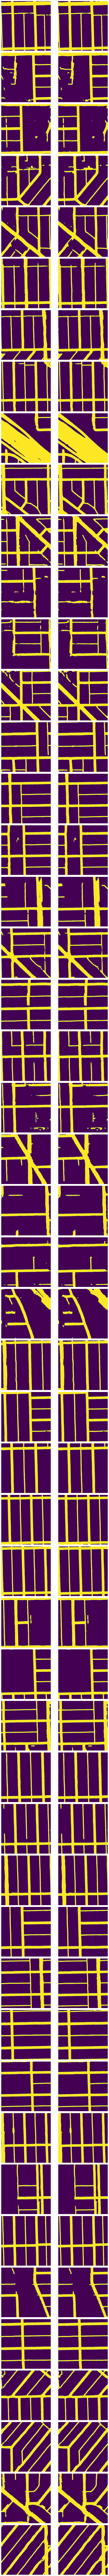

In [14]:
# morphological operations
# performance gets worse for test
import cv2
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=50, ncols=2, figsize=(10, 200))
ax = ax.flatten()

kernel_open = np.ones((5, 5), np.uint8)
kernel_close = np.ones((8, 8), np.uint8)
for idx in range(50):
    img = cv2.imread(f"saved_images_test/pred_{idx+1}.png", cv2.IMREAD_GRAYSCALE)
    ax[2*idx].imshow(img)
    ax[2*idx].axis('off')
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_close)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_open)
    ax[2*idx+1].imshow(img)
    ax[2*idx+1].axis('off')
    # cv2.imwrite(f"saved_images_test/pred_{idx+1}.png", img)
plt.tight_layout()
plt.show()
